Install requirements

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Imports

In [2]:
# data processing
import pandas as pd
import numpy as np
import glob
import re
from scipy.stats import zscore

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning library
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Preprocess_and_clean_data

In [3]:
def concat_csvs(path: str ='data/*.csv') -> pd.DataFrame:
    csv_files = glob.glob(path)
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)
    return pd.concat(dfs, axis=0, ignore_index=True)

def lower_and_fix_col_names(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.lower()
    df.rename(columns={"messurements": "measurements", "colour": "color"}, inplace=True)
    return df

def split_measurements(df: pd.DataFrame) -> pd.DataFrame:
    new_columns = ["length", "width", "depth"]

    def extract_numbers(measurement_str):
        return map(float, re.findall(r"\d+\.\d+|\d+", measurement_str))

    extracted_data = [list(extract_numbers(entry)) for entry in df["measurements"].astype(str)]
    df[new_columns] = pd.DataFrame(extracted_data, columns=new_columns, dtype=np.float64)
    df = df.drop('measurements', axis=1)
    return df

def convert_price(df: pd.DataFrame) -> pd.DataFrame:
    df['price'] = df['price'].str.replace(',', '').astype('float64')
    return df

df = concat_csvs('data/*.csv')
df = lower_and_fix_col_names(df)
df = split_measurements(df)
df = convert_price(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6339 non-null   object 
 1   shape         6339 non-null   object 
 2   weight        6339 non-null   float64
 3   clarity       6319 non-null   object 
 4   color         6339 non-null   object 
 5   cut           6337 non-null   object 
 6   polish        6338 non-null   object 
 7   symmetry      6332 non-null   object 
 8   fluorescence  6337 non-null   object 
 9   price         6339 non-null   float64
 10  length        6339 non-null   float64
 11  width         6339 non-null   float64
 12  depth         6339 non-null   float64
dtypes: float64(5), object(8)
memory usage: 643.9+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
def encode_shape(df: pd.DataFrame) -> pd.DataFrame:
    encoded_df = pd.get_dummies(df['shape'], prefix='shape')
    df = pd.concat([df, encoded_df], axis=1)
    return df

def encode_clarity(df: pd.DataFrame) -> pd.DataFrame:
    clarity_order = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
    encoder = OrdinalEncoder(categories=[clarity_order])
    df['encoded_clarity'] = encoder.fit_transform(df[['clarity']])
    return df

def encode_color(df: pd.DataFrame) -> pd.DataFrame:
    color_order = ['FANCY', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'O-P', 'Q-R', 'S-T', 'U-V', 'W', 'W-X', 'Y-Z']
    encoder = OrdinalEncoder(categories=[color_order])
    df['encoded_color'] = encoder.fit_transform(df[['color']])
    return df

def encode_cut(df: pd.DataFrame) -> pd.DataFrame:
    cut_order = ['EX', 'VG', 'GD', 'F']
    encoder = OrdinalEncoder(categories=[cut_order])
    df['encoded_cut'] = encoder.fit_transform(df[['cut']])
    return df

def encode_polish(df: pd.DataFrame) -> pd.DataFrame:
    polish_order = ['EX', 'VG', 'GD', 'F']
    encoder = OrdinalEncoder(categories=[polish_order])
    df['encoded_polish'] = encoder.fit_transform(df[['polish']])
    return df

def encode_symmetry(df: pd.DataFrame) -> pd.DataFrame:
    symmetry_order = ['EX', 'VG', 'GD', 'FR']
    encoder = OrdinalEncoder(categories=[symmetry_order])
    df['encoded_symmetry'] = encoder.fit_transform(df[['symmetry']])
    return df

def encode_fluorescence(df: pd.DataFrame) -> pd.DataFrame:
    fluorescence_order = ['N', 'VSL', 'SL', 'F', 'M', 'ST', 'VS']
    encoder = OrdinalEncoder(categories=[fluorescence_order])
    df['encoded_fluorescence'] = encoder.fit_transform(df[['fluorescence']])
    return df

def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
    df = encode_shape(df)
    df = encode_clarity(df)
    df = encode_color(df)
    df = encode_cut(df)
    df = encode_polish(df)
    df = encode_symmetry(df)
    df = encode_fluorescence(df)
    return df

df = encode_categorical(df)
df.describe()

,weight,price,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,shape_MARQUISE,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
count,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000
mean,0.622448,2446.604337,5.422374,4.788970,3.087118,0.262082,0.091745,0.054666,0.010775,0.105847,0.050230,0.098875,0.325780,4.939312,4.253842,0.342576,0.210743,0.910157,1.074315
std,0.382771,4044.123266,1.202607,0.749416,0.512040,0.439802,0.288688,0.227346,0.103249,0.307666,0.218436,0.298518,0.468703,1.574850,3.004153,0.597054,0.434946,0.704531,1.678245
min,0.180000,683.220000,3.540000,3.010000,1.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.430000,1292.555000,4.710000,4.350000,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,1881.820000,5.100000,4.890000,3.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,0.000000,0.000000,1.000000,0.000000
75%,0.710000,2232.640000,5.850000,5.160000,3.310000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,1.000000,0.000000,1.000000,3.000000
max,6.020000,76147.680000,12.520000,9.850000,6.660000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,19.000000,3.000000,3.000000,3.000000,6.000000


In [7]:
# Remove price outliers
z_score = zscore(df['price']) 
threshold = 3
df = df[abs(z_score) < threshold]
df.to_csv('data/processed_data/diamond_features.csv', index=False)

In [8]:
df.describe()

,weight,price,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,shape_MARQUISE,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
count,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000
mean,0.597001,2079.634171,5.372983,4.755067,3.063999,0.257184,0.092952,0.055386,0.010917,0.107240,0.046075,0.100177,0.330069,4.939798,4.272596,0.343715,0.212715,0.917322,1.066463
std,0.293683,1448.599718,1.116899,0.686268,0.467528,0.437117,0.290389,0.228751,0.103919,0.309443,0.209664,0.300259,0.470275,1.570053,3.007727,0.598798,0.436595,0.703969,1.672460
min,0.180000,683.220000,3.540000,3.010000,1.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.420000,1287.100000,4.700000,4.350000,2.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,1865.760000,5.090000,4.870000,3.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,0.000000,0.000000,1.000000,0.000000
75%,0.700000,2187.190000,5.800000,5.150000,3.290000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,1.000000,0.000000,1.000000,3.000000
max,3.710000,13643.460000,12.050000,8.370000,5.740000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,19.000000,3.000000,3.000000,3.000000,6.000000


In [9]:
df = pd.read_csv('data/processed_data/diamond_features.csv')

2. Data Analysis

Visualization 1: Bar plots for categorical features and histograms with KDE for numerical features.

I think it's important as a first step of EDA to use that visualization because it provides us with a clear view of the distribution of both of these types.
The KDE helps us capture important features such as skewness and modality.
In addition, this visualization can help us identify data quality issues like outliers and help us asses feature importance and relevance with regard to the target feature. 
Meaning, helps you see which feature values are represented well within the dataset and which are not, and that may influence the impact on the target feature.
In our case, if we take for example the target feature - price, we have an imbalanced distribution which is unimodal and right-skewed.

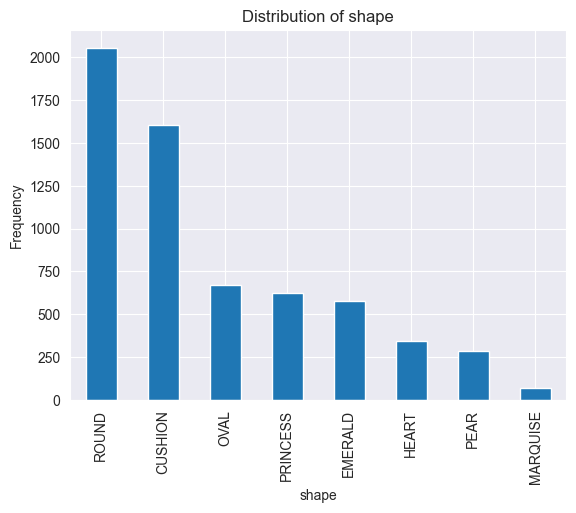

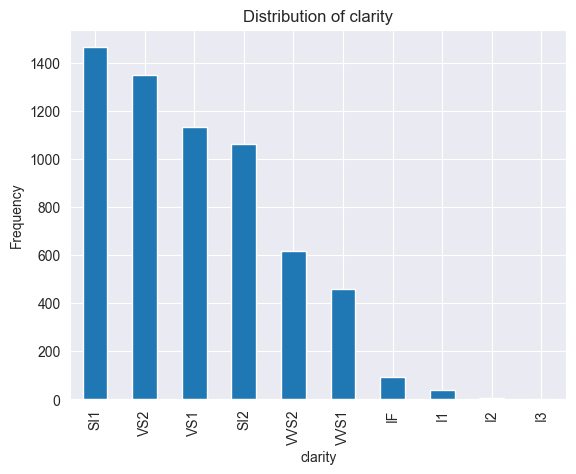

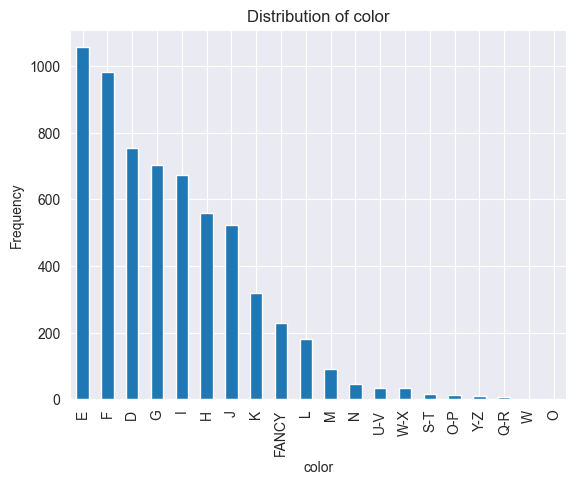

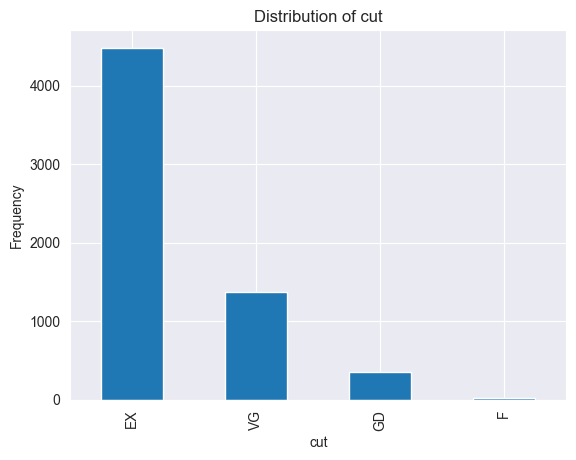

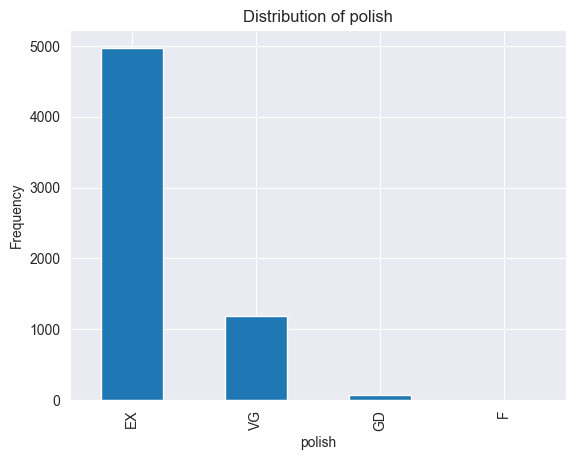

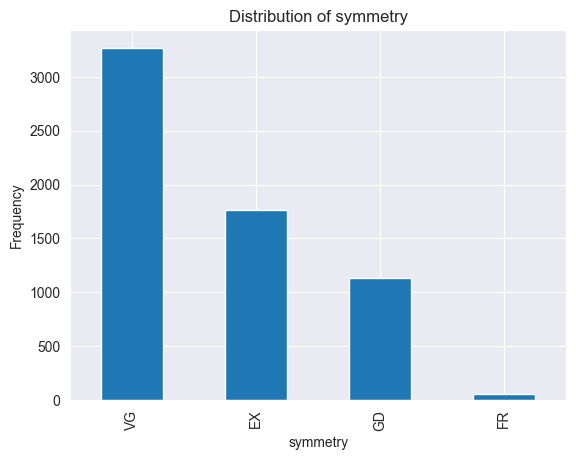

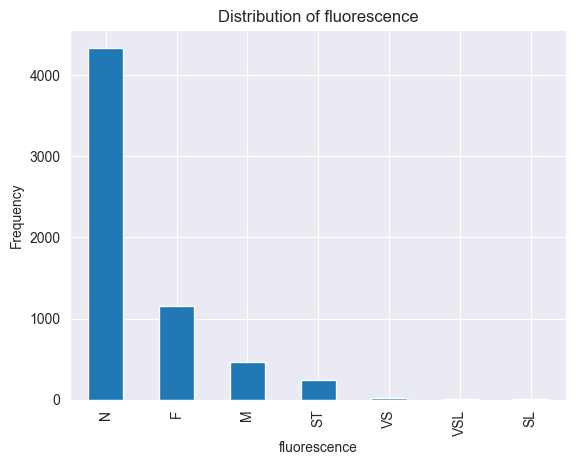

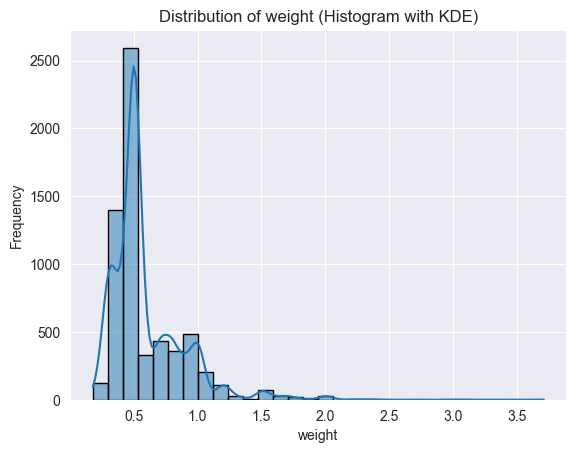

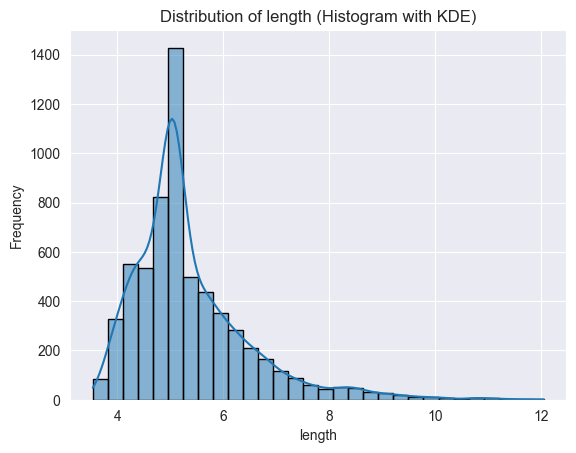

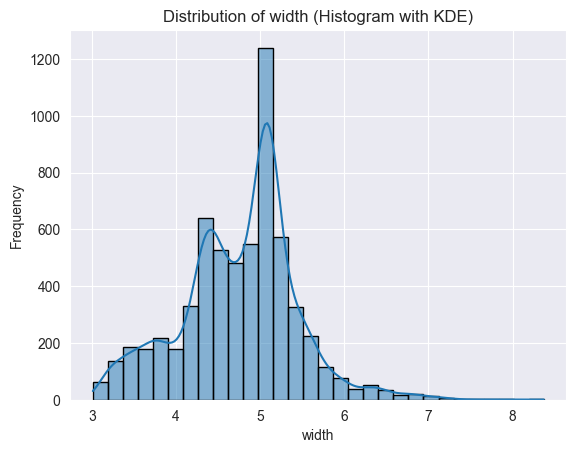

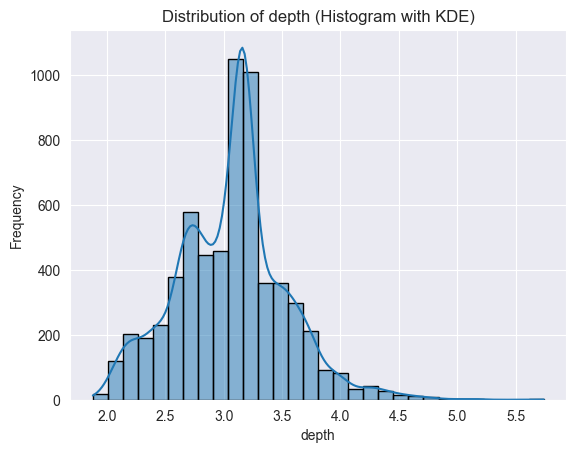

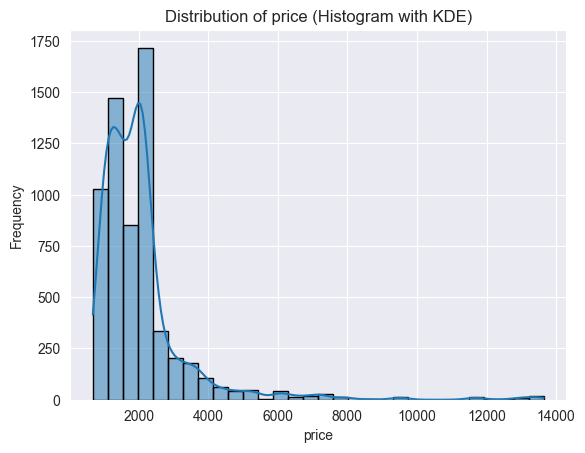

In [10]:
# Categorical Columns: Visualized as bar plots
categorical_columns = ['shape', 'clarity', 'color', 'cut', 'polish', 'symmetry', 'fluorescence']

for column in categorical_columns:
    value_counts = df[column].value_counts()
    value_counts.plot(kind='bar', title=f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    
# Numerical Columns: Visualized as histograms with KDE
numerical_columns = ['weight', 'length', 'width', 'depth', 'price']
for column in numerical_columns:
    sns.histplot(df[column], bins=30, kde=True, edgecolor='black')
    plt.title(f'Distribution of {column} (Histogram with KDE)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    

Visualization 2: correlation between features and the target feature (price).

I think this visualization is important because it helps us identify relationships between the target and the other features.
Not less important, it helps us identify relationship between the other features.
In our case: We can spot that the price is highly correlated with the weight of the diamond, but, in addition: weight, width, length, and depth are correlated as well and that means they provide overlapping information and thus some might be redundant.

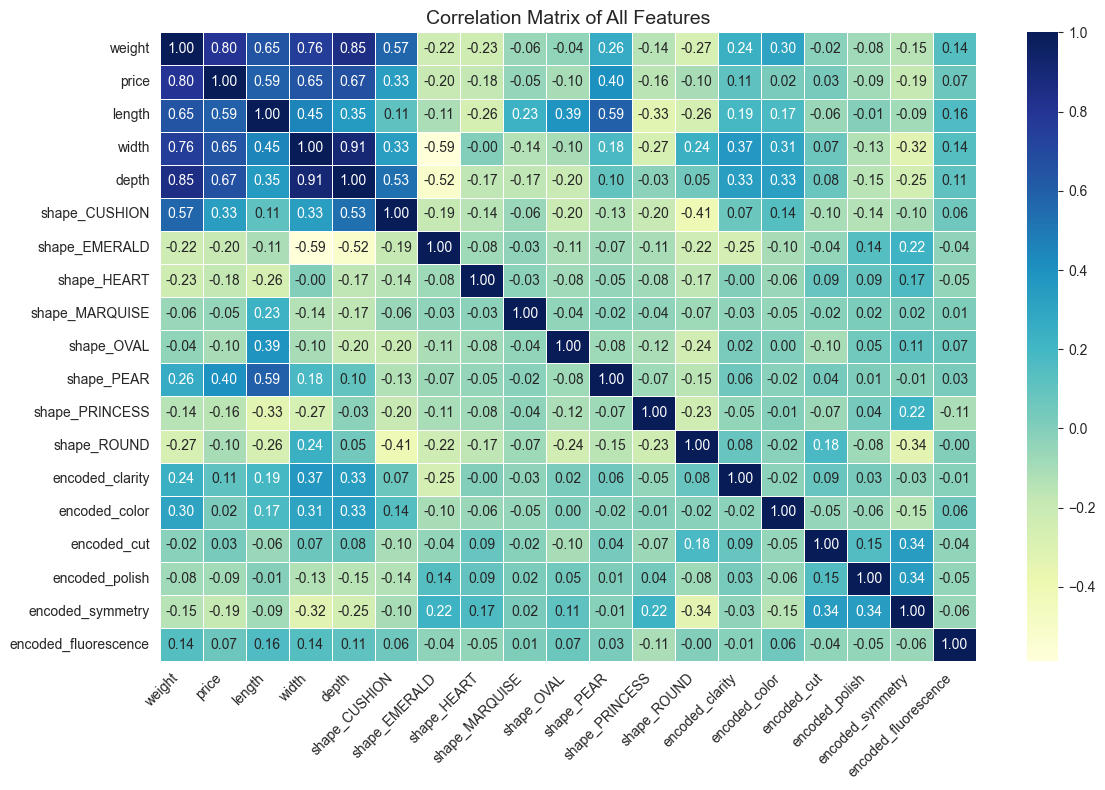

In [11]:
# Calculate correlation between all features
df_corr = df.corr(method='pearson')

# Create a larger figure for better readability
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust width and height as needed

# Plot the heatmap
sns.heatmap(
    df_corr, 
    annot=True, 
    fmt='.2f', 
    cmap="YlGnBu", 
    cbar=True, 
    linewidths=0.5, 
    ax=ax
)

# Adjust tick label rotation for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Correlation Matrix of All Features', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Visualization 3: violin plot of the price given a binned weight (binned by 0.5 jumps up to 3 because for sizes bigger than that the data is really sparse), where each bin includes the number of instances.

Violin plots capture some aspects of the box plot with a detailed distribution data by the KDE.
In our case: we can see that as we get to a bin that holds a larger weight span, the median prices increase as well, and it's hard to see, but I think that it's also in growing fashion. In addition, we can see that as we get to a bin that holds a larger weight span the distribution of prices grows larger (with exemption of the rightmost bin that has only 2 samples), and finally of course we can get a feel of the densities.

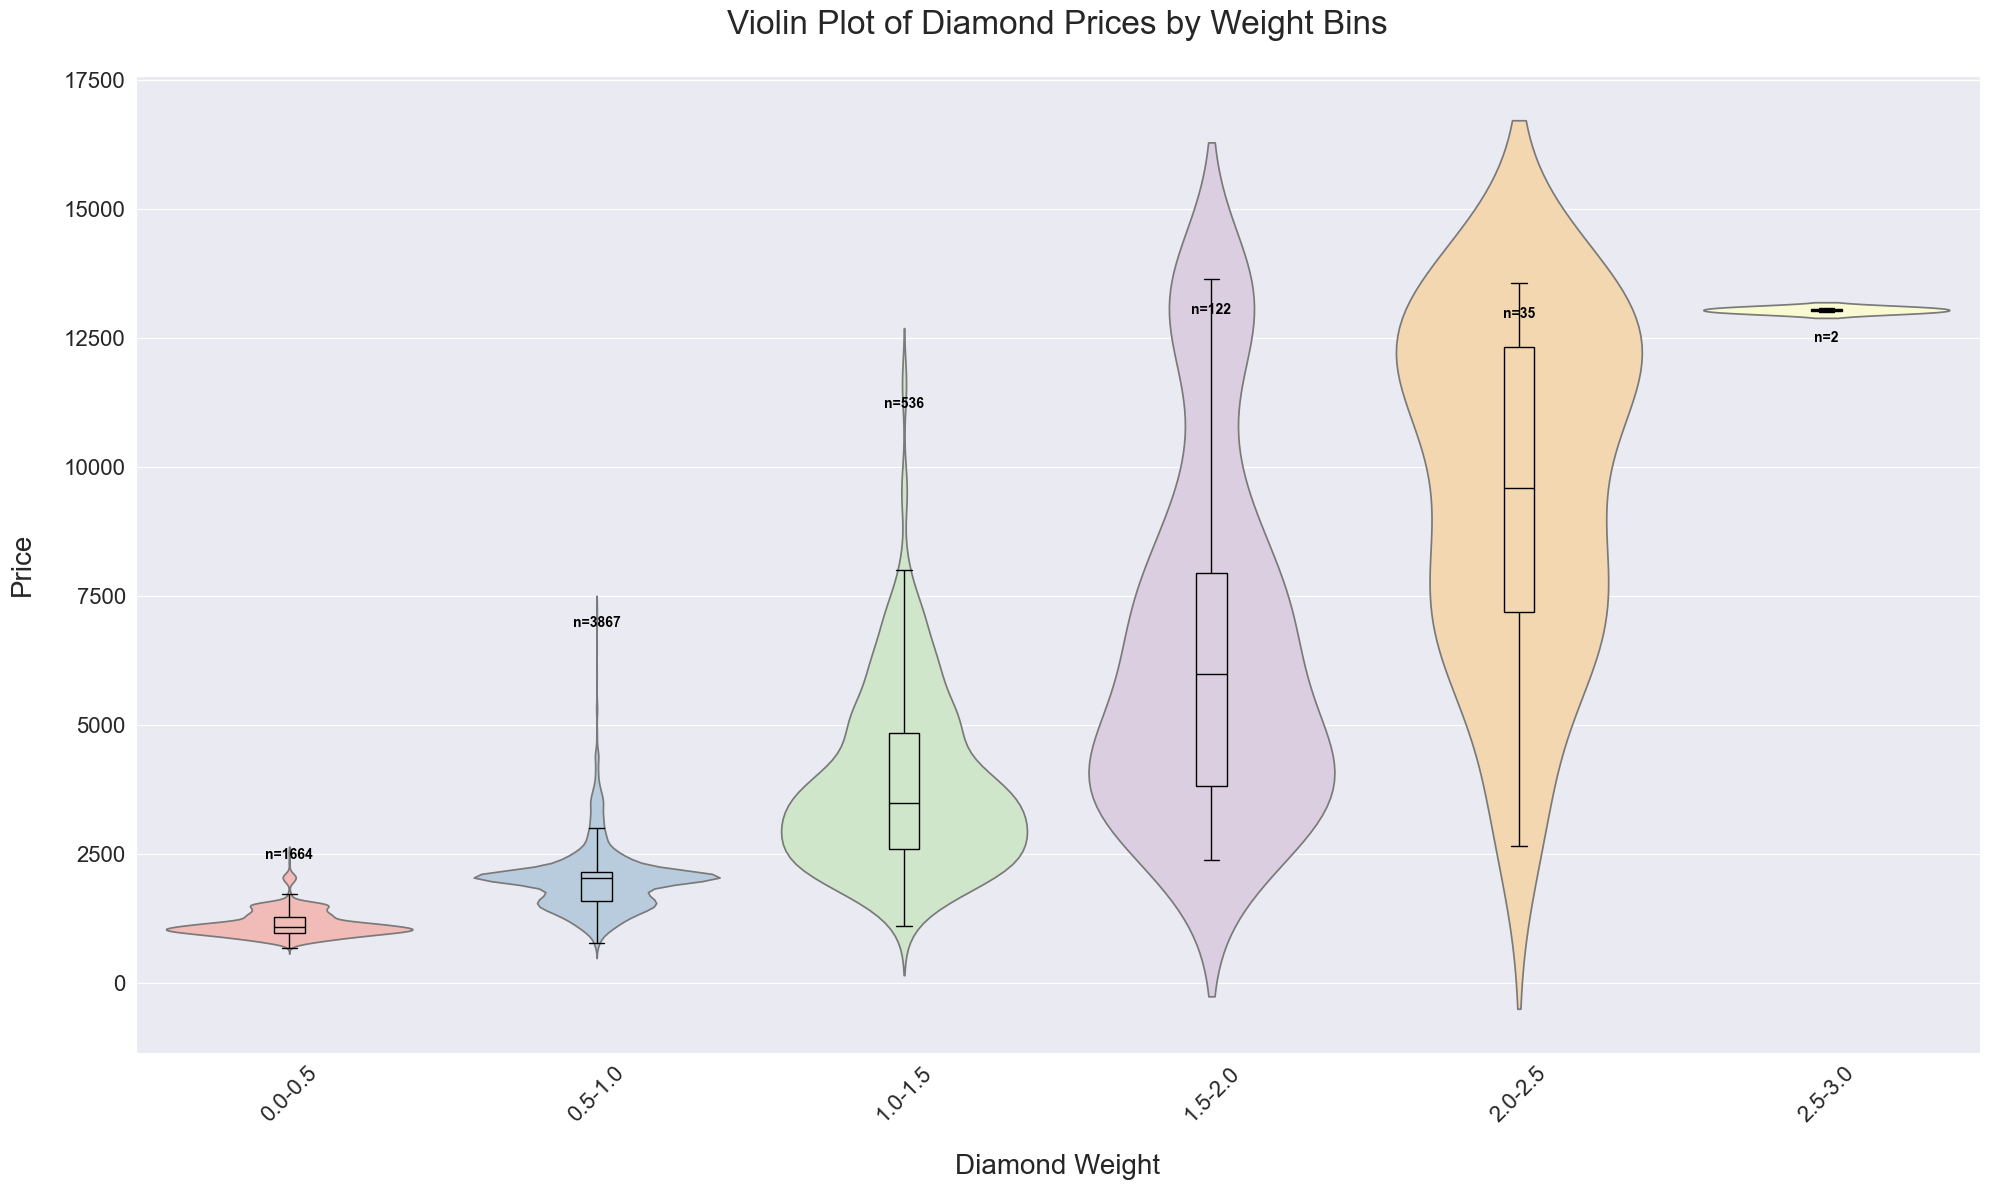

In [12]:
# 1. Define the bin edges
bin_width = 0.5
num_bins = 6
bins = [i * bin_width for i in range(num_bins + 1)]  

# 2. Assign each diamond to a weight bin
df['weight_bin'] = pd.cut(df['weight'], bins=bins, right=False, include_lowest=True)

# 3. Create bin labels as strings for better readability
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df['weight_bin_label'] = df['weight_bin'].apply(lambda x: f"{x.left}-{x.right}")

# 4. Count the number of instances per bin
bin_counts = df['weight_bin_label'].value_counts().reindex(bin_labels)

# 5. Initialize the matplotlib figure with a larger size and constrained layout
fig, ax = plt.subplots(figsize=(20, 12), constrained_layout=True)

# 6. Create the violin plot
sns.violinplot(
    x='weight_bin_label',
    y='price',
    data=df,
    order=bin_labels,
    inner=None,  # Remove default inner annotations
    palette='Pastel1',
    ax=ax
)

# 7. Overlay the box plot for additional summary statistics
sns.boxplot(
    x='weight_bin_label',
    y='price',
    data=df,
    order=bin_labels,
    width=0.1,
    showcaps=True,
    boxprops={'facecolor':'none'},
    showfliers=False,
    whiskerprops={'linewidth':1},
    saturation=1,
    color='k',
    ax=ax
)

# 8. Add count labels within each violin
for i, bin_label in enumerate(bin_labels):
    count = bin_counts[bin_label]
    # Find the maximum price in the current bin
    bin_data = df[df['weight_bin_label'] == bin_label]['price']
    if not bin_data.empty:
        bin_max_price = bin_data.max()
        label_y = bin_max_price * 0.95  # 95% of the bin's max price
        ax.text(
            i,
            label_y,
            f'n={count}',
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='semibold'
        )

# 9. Customize the plot with titles and labels
ax.set_title('Violin Plot of Diamond Prices by Weight Bins', fontsize=24, pad=30)
ax.set_xlabel('Diamond Weight', fontsize=20, labelpad=20)
ax.set_ylabel('Price', fontsize=20, labelpad=20)
ax.tick_params(axis='x', labelrotation=45, labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# 10. Adjust layout to prevent clipping
plt.tight_layout()

# 11. Display the plot
plt.show()

Visualization 4: box plot of the encoded clarity's effect on the price (with and without outliers).

Box plots are beneficial for simplicity and clarity whenever we want to communicate some key summary statistics such as the median, quartiles and outliers.
In our case, according to the pearson correlation based heatmap we plotted above there's a relatively strong connection between symmetry and price, note that it's negative due to the fact that the ordering in which we encoded the data is lower -> better.
We can see that as the symmetry grade gets better the median price is getting higher (the same goes for the Q1 and Q3 markers). In addition, we can see that there are quite a few outliers for the premier 3 categories, that can be explained by the fact that they are the most represented categories for this feature, and lastly the IQR's of the VG and GD are the biggest followed by EX and then FR.



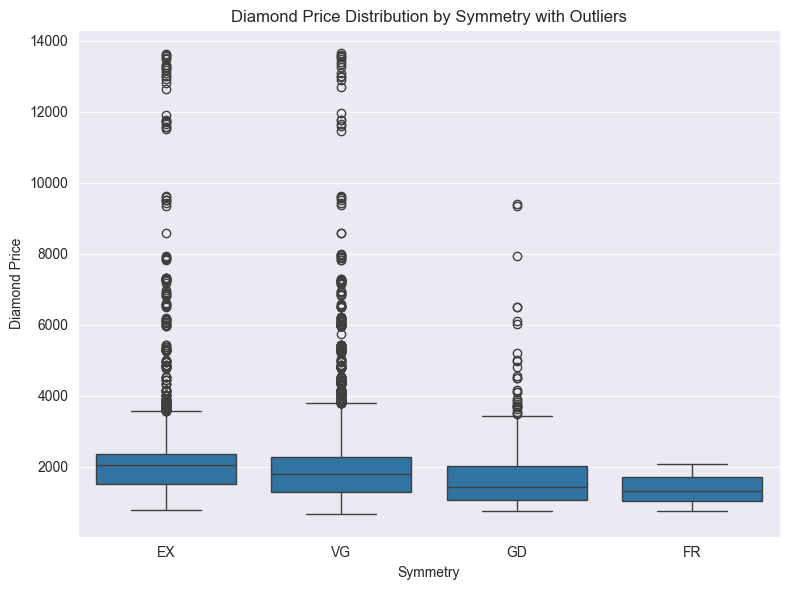

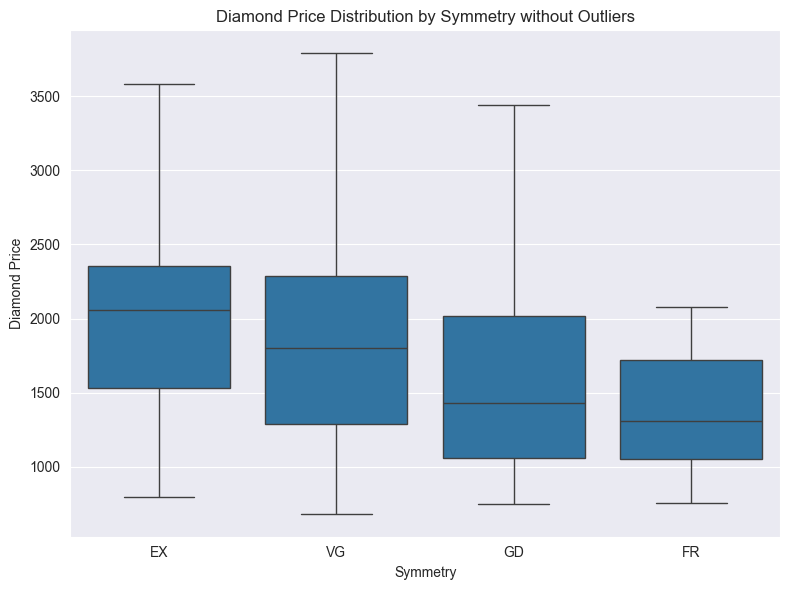

In [13]:
# Define the order of symmetry categories
symmetry_order = ['EX', 'VG', 'GD', 'FR']

# Box plot with outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='symmetry', y='price', data=df, order=symmetry_order)
plt.xlabel('Symmetry')
plt.ylabel('Diamond Price')
plt.title('Diamond Price Distribution by Symmetry with Outliers')
plt.tight_layout()
plt.show()

# Box plot without outliers
plt.figure(figsize=(8, 6))  # Initialize a new figure
sns.boxplot(x='symmetry', y='price', data=df, order=symmetry_order, showfliers=False)
plt.xlabel('Symmetry')
plt.ylabel('Diamond Price')
plt.title('Diamond Price Distribution by Symmetry without Outliers')
plt.tight_layout()
plt.show()


Visualization 5: box plot of the diamond shapes and their counts, filtered by the most common values of the most correlated features (weight and symmetry), effect on the price.

Again, I used box plots for this visualization because of their simplicity in communicating important statistical measures.
In this case I tried to see if I can try and neutralize some of the effect of the two most correlated features and see how that impacts on the relation of Shape - Price.
The reason I chose to do that is because there are shapes who had stronger correlation with price according to the heatmap and some had weaker but overall this feature seems to be pretty correlated with regard to other features.
I found that the pear shape has the highest mean followed by the cushion and round shapes. In addition, the IQR for the pear shape is significantly wider than any other shape (followed by cushion which is about 3/5 as wide). It seems that round diamond prices are significantly less variable than the other shape if we don't take into account some shapes with low count such as marquise and heart.

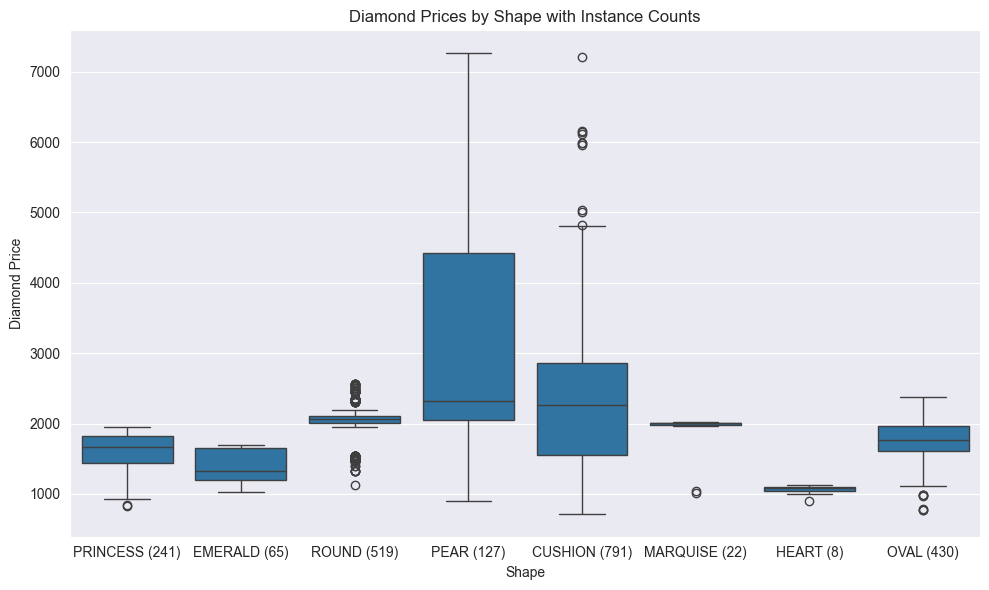

In [14]:
# Define the weight range, symmetry, and filter the DataFrame
lower = 0.5
upper = 1.0
filtered_df = df[
    (df['weight'] >= lower) &
    (df['weight'] <= upper) &
    (df['symmetry'] >= 'VG') 
]

# Calculate counts per shape
shape_counts = filtered_df['shape'].value_counts().sort_index()

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the box plot using the filtered DataFrame
ax = sns.boxplot(x='shape', y='price', data=filtered_df)

# Set plot labels and title
plt.xlabel('Shape')
plt.ylabel('Diamond Price')
plt.title('Diamond Prices by Shape with Instance Counts')

# Retrieve current x-axis labels
current_labels = [item.get_text() for item in ax.get_xticklabels()]

# Create new labels with counts
new_labels = [f"{label} ({shape_counts.get(label, 0)})" for label in current_labels]

# Update the x-axis tick labels
ax.set_xticklabels(new_labels)

# Improve layout and display the plot
plt.tight_layout()
plt.show()



3. Basic Model Pipeline - XGBoost

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6229 entries, 0 to 6228
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    6229 non-null   object  
 1   shape                 6229 non-null   object  
 2   weight                6229 non-null   float64 
 3   clarity               6229 non-null   object  
 4   color                 6229 non-null   object  
 5   cut                   6229 non-null   object  
 6   polish                6229 non-null   object  
 7   symmetry              6229 non-null   object  
 8   fluorescence          6229 non-null   object  
 9   price                 6229 non-null   float64 
 10  length                6229 non-null   float64 
 11  width                 6229 non-null   float64 
 12  depth                 6229 non-null   float64 
 13  shape_CUSHION         6229 non-null   int64   
 14  shape_EMERALD         6229 non-null   int64   
 15  shap

In [16]:
# List of columns to select
columns_to_select = [
    'weight', 'price', 'length', 'width', 'depth',
    'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
    'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR',
    'shape_PRINCESS', 'shape_ROUND', 'encoded_clarity',
    'encoded_color', 'encoded_cut', 'encoded_polish',
    'encoded_symmetry', 'encoded_fluorescence'
]

# Select the specified columns from the DataFrame
df_inference = df[columns_to_select]

# Define features and target
X = df_inference.drop('price', axis=1)  # Features
y = df_inference['price']               # Target (price)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Save split datasets
X_train.to_csv('data/dataset_split/X_train.csv', index=False)
X_test.to_csv('data/dataset_split/X_test.csv', index=False)
y_train.to_csv('data/dataset_split/y_train.csv', index=False)
y_test.to_csv('data/dataset_split/y_test.csv', index=False)

# Initialize and train the XGBoost regressor
xg_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
xg_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_regressor.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Create a DataFrame for comparison
# Reset indices to ensure alignment
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='predicted')

# Concatenate features, actual, and predicted values
comparison_df = pd.concat([y_test_reset.rename('actual'), y_pred_series, X_test_reset], axis=1)

# Create an error column
comparison_df['error'] = abs(comparison_df['actual'] - comparison_df['predicted'])

# Reorder the error column to be the 3rd column from the left
comparison_df.insert(2, 'error', comparison_df.pop('error'))

# Display the first 50 rows of the comparison DataFrame
comparison_df.head(10)


Mean Absolute Error: 191.3118530822068


,actual,predicted,error,weight,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,...,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
0,4029.32,4499.106445,469.786445,1.20,5.97,5.82,3.95,1,0,0,...,0,0,0,0,6.0,6.0,0.0,0.0,1.0,3.0
1,2039.46,2086.489990,47.029990,0.50,5.04,5.07,3.16,0,0,0,...,0,0,0,1,7.0,2.0,0.0,0.0,0.0,0.0
2,6840.40,8018.085938,1177.685938,1.51,9.46,6.30,4.03,0,0,0,...,0,1,0,0,7.0,7.0,1.0,0.0,0.0,4.0
3,1551.61,1678.729614,127.119614,0.51,4.56,4.47,3.04,0,0,0,...,0,0,1,0,6.0,4.0,0.0,0.0,1.0,0.0
4,1315.39,1312.531372,2.858628,0.51,4.34,4.31,3.14,0,0,0,...,0,0,1,0,5.0,7.0,0.0,0.0,2.0,0.0
5,5289.38,5155.724121,133.655879,1.02,5.93,5.62,3.71,1,0,0,...,0,0,0,0,5.0,4.0,0.0,0.0,0.0,0.0
6,2073.85,2057.746826,16.103174,0.50,4.92,4.96,3.19,0,0,0,...,0,0,0,1,6.0,3.0,1.0,0.0,2.0,0.0
7,3389.88,3214.664551,175.215449,0.83,5.97,5.01,3.35,1,0,0,...,0,0,0,0,5.0,2.0,0.0,0.0,1.0,0.0
8,1443.29,1362.738770,80.551230,0.41,3.97,3.95,2.88,0,0,0,...,0,0,1,0,4.0,4.0,0.0,0.0,1.0,0.0
9,1409.15,1590.615479,181.465479,0.50,5.18,3.83,2.61,0,1,0,...,0,0,0,0,6.0,3.0,0.0,0.0,1.0,0.0


Save model

In [17]:
def save_model_xgboost(model, model_name='base_model.json'):
    """
    Saves the trained XGBoost model to the specified file path.

    Parameters:
    - model: The trained XGBoost model to save.
    - file_path (str): The path where the model will be saved.
    """
    model.save_model('models/' + model_name)
    print(f"XGBoost model successfully saved to {'models/' + model_name}.")

In [18]:
save_model_xgboost(xg_regressor)

XGBoost model successfully saved to models/base_model.json.


Let's verify that our train-test split is a good one, meaning that we have in each of the split distributions a good representation of the underlying distribution.
We can see using the histogram and KDE visualization that it is indeed the case.

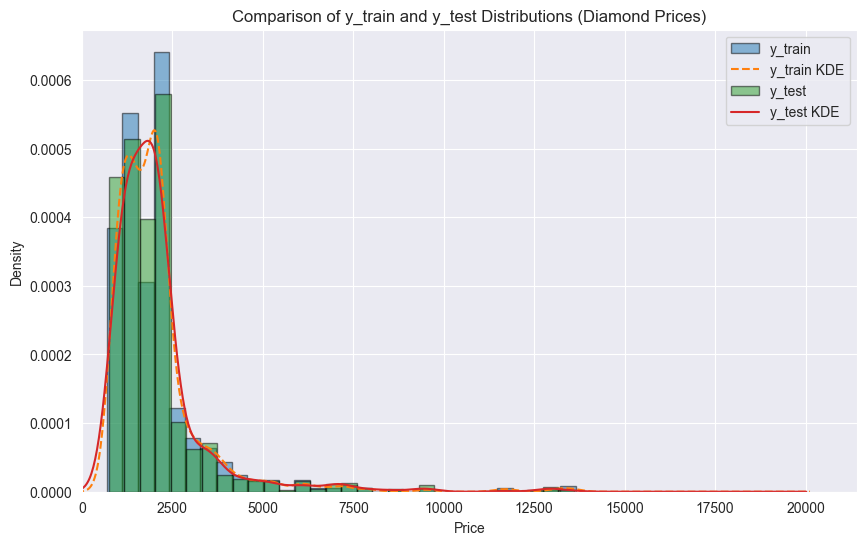

In [19]:
# Plot histograms and KDE for y_train and y_test
plt.figure(figsize=(10, 6))

# Histogram and KDE for y_train
plt.hist(y_train, bins=30, density=True, alpha=0.5, label='y_train', edgecolor='k')
pd.Series(y_train).plot(kind='kde', label='y_train KDE', linestyle='--')

# Histogram and KDE for y_test
plt.hist(y_test, bins=30, density=True, alpha=0.5, label='y_test', edgecolor='k')
pd.Series(y_test).plot(kind='kde', label='y_test KDE', linestyle='-')

# Set x-axis limits to start at 0
plt.xlim(left=0)

# Add labels and title
plt.title('Comparison of y_train and y_test Distributions (Diamond Prices)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


4. Error analysis

In [20]:
baseline_r2_score = r2_score(y_test, y_pred)
print(f'Baseline R² Score: {baseline_r2_score:.4f}')

Baseline R² Score: 0.8566


In [21]:
# Calculate the Mean Absolute Percentage Error
baseline_mean_absolute_perc_error = mean_absolute_percentage_error(y_test, y_pred)

# Calculate the Mean Absolute Error
baseline_mean_absolute_error_val = mean_absolute_error(y_test, y_pred)

# Calculate the Mean Squared Error
baseline_mean_squared_error = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error
baseline_root_mean_squared_error = np.sqrt(baseline_mean_squared_error)

# Print the error metrics 
print(f"Mean Absolute Perc Error (Σ(|y - pred|/y)/n): {baseline_mean_absolute_perc_error:.4f}")
print(f"Mean Absolute Error (Σ|y - pred|/n): {baseline_mean_absolute_error_val:.4f}")
print(f"Mean Squared Error (Σ(y - pred)^2/n): {baseline_mean_squared_error:.4f}")
print(f"Root Mean Squared Error (sqrt(Σ(y - pred)^2/n))): {baseline_root_mean_squared_error}")


## residuals
residuals = y_test - y_pred
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]
#max_true, max_pred = y_test.loc[max_idx], prediction[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.0692
Mean Absolute Error (Σ|y - pred|/n): 191.3119
Mean Squared Error (Σ(y - pred)^2/n): 298963.2332
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n))): 546.7753040791342
Max Error: 6,709


Let's see a plot of the predicted price (the X axis value) versus the actual price (the Y axis value):
We can see clearly that as the real price of the diamond increases there's more of a tendency to miss-predict by larger margins.
Let's take a look at the perfect prediction line we have drawn at the (6000, 6000) point, if we split the graph to two parts in our imagination (top and bottom), 
we can see pretty clearly that the samples at the top part tend to be further from the perfect prediction line

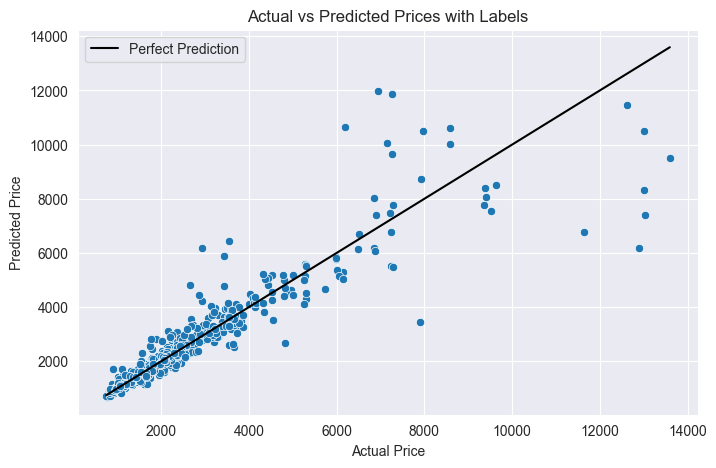

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, ax=ax)
sns.lineplot(x=y_test, y=y_test, ax=ax, color='black', label='Perfect Prediction')

# Customize the plot
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Actual vs Predicted Prices with Labels')

plt.show()

In [23]:
comparison_df.head(10)

,actual,predicted,error,weight,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,...,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
0,4029.32,4499.106445,469.786445,1.20,5.97,5.82,3.95,1,0,0,...,0,0,0,0,6.0,6.0,0.0,0.0,1.0,3.0
1,2039.46,2086.489990,47.029990,0.50,5.04,5.07,3.16,0,0,0,...,0,0,0,1,7.0,2.0,0.0,0.0,0.0,0.0
2,6840.40,8018.085938,1177.685938,1.51,9.46,6.30,4.03,0,0,0,...,0,1,0,0,7.0,7.0,1.0,0.0,0.0,4.0
3,1551.61,1678.729614,127.119614,0.51,4.56,4.47,3.04,0,0,0,...,0,0,1,0,6.0,4.0,0.0,0.0,1.0,0.0
4,1315.39,1312.531372,2.858628,0.51,4.34,4.31,3.14,0,0,0,...,0,0,1,0,5.0,7.0,0.0,0.0,2.0,0.0
5,5289.38,5155.724121,133.655879,1.02,5.93,5.62,3.71,1,0,0,...,0,0,0,0,5.0,4.0,0.0,0.0,0.0,0.0
6,2073.85,2057.746826,16.103174,0.50,4.92,4.96,3.19,0,0,0,...,0,0,0,1,6.0,3.0,1.0,0.0,2.0,0.0
7,3389.88,3214.664551,175.215449,0.83,5.97,5.01,3.35,1,0,0,...,0,0,0,0,5.0,2.0,0.0,0.0,1.0,0.0
8,1443.29,1362.738770,80.551230,0.41,3.97,3.95,2.88,0,0,0,...,0,0,1,0,4.0,4.0,0.0,0.0,1.0,0.0
9,1409.15,1590.615479,181.465479,0.50,5.18,3.83,2.61,0,1,0,...,0,0,0,0,6.0,3.0,0.0,0.0,1.0,0.0


Identifying Items with Worst and Best Performance:
On which items the model performs the worst? The best? Why do you think that is?
As we can see from the 20 worst and best predictions, as well as the scatter plot of predicted prices vs actual prices, we can notice that the mid-high actual prices are a significant chunk of the 20 worst predictions and in contrast the mid-low actual prices are a significant chunk of the 20 best predictions.
We explained why that is when we explained the reason for our model under/over estimation.
Are you able to find commonalities between the erroneous samples?
Yes. The top 20 worst predictions are all of shapes Cushion and Pear.
This comes as no surprise since if you'd look above at visualization 5 you'll see that these shapes had the biggest IQR, and on top of that the longest whiskers (These lines extend from the box to the smallest and largest values within 1.5 times the IQR from the lower and upper quartiles, respectively) and some outliers. That means wider range and increased variability. 


Top 20 Worst Predictions:


,actual,predicted,error,weight,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,shape_MARQUISE,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
700,12892.04,6182.559082,6709.480918,1.51,6.62,6.54,4.44,1,0,0,0,0,0,0,0,5.0,3.0,0.0,0.0,1.0,0.0
1083,13019.69,7400.472168,5619.217832,3.02,9.00,7.50,5.07,1,0,0,0,0,0,0,0,3.0,18.0,0.0,0.0,0.0,0.0
611,6937.91,11972.866211,5034.956211,1.51,9.97,6.24,4.08,0,0,0,0,0,1,0,0,3.0,3.0,0.0,0.0,0.0,0.0
171,11643.30,6757.568359,4885.731641,2.01,6.79,6.72,4.67,1,0,0,0,0,0,0,0,4.0,0.0,1.0,0.0,1.0,0.0
198,12997.82,8306.200195,4691.619805,3.00,8.23,7.98,5.09,1,0,0,0,0,0,0,0,2.0,18.0,0.0,0.0,0.0,4.0
472,7252.10,11859.829102,4607.729102,1.50,10.18,6.39,3.79,0,0,0,0,0,1,0,0,4.0,3.0,1.0,0.0,0.0,0.0
934,7898.48,3440.829590,4457.650410,1.72,6.51,6.51,4.41,1,0,0,0,0,0,0,0,7.0,0.0,0.0,0.0,1.0,3.0
88,6182.97,10638.516602,4455.546602,1.71,7.87,6.52,4.44,1,0,0,0,0,0,0,0,4.0,4.0,0.0,0.0,1.0,0.0
540,13595.21,9523.153320,4072.056680,1.90,11.44,6.79,4.04,0,0,0,0,0,1,0,0,6.0,7.0,0.0,0.0,0.0,0.0
845,2939.62,6170.885254,3231.265254,1.00,8.72,5.69,3.32,0,0,0,0,0,1,0,0,5.0,4.0,1.0,1.0,1.0,0.0



Top 20 Best Predictions:


,actual,predicted,error,weight,length,width,depth,shape_CUSHION,shape_EMERALD,shape_HEART,shape_MARQUISE,shape_OVAL,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence
806,1134.18,1134.230103,0.050103,0.35,4.36,4.92,2.76,0,0,1,0,0,0,0,0,3.0,4.0,0.0,1.0,2.0,0.0
1148,1369.42,1369.253296,0.166704,0.42,5.24,3.48,2.29,0,1,0,0,0,0,0,0,4.0,5.0,0.0,0.0,1.0,0.0
217,1030.06,1029.863647,0.196353,0.30,4.75,3.09,2.10,0,1,0,0,0,0,0,0,2.0,3.0,0.0,1.0,2.0,0.0
181,1005.80,1005.581116,0.218884,0.30,4.35,4.58,2.56,0,0,1,0,0,0,0,0,4.0,4.0,2.0,1.0,2.0,0.0
282,1658.80,1658.517212,0.282788,0.51,5.19,3.81,2.60,0,1,0,0,0,0,0,0,3.0,5.0,0.0,0.0,1.0,0.0
980,1773.02,1772.538330,0.481670,0.59,4.96,4.55,3.09,1,0,0,0,0,0,0,0,3.0,5.0,0.0,0.0,1.0,0.0
591,4156.69,4156.169434,0.520566,0.99,5.59,5.56,3.76,1,0,0,0,0,0,0,0,6.0,4.0,0.0,0.0,1.0,0.0
427,2105.01,2104.229492,0.780508,0.50,4.93,4.96,3.18,0,0,0,0,0,0,0,1,5.0,4.0,2.0,0.0,2.0,0.0
1137,1184.12,1183.333252,0.786748,0.31,4.53,3.33,2.24,0,1,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,0.0
657,2089.58,2088.729004,0.850996,0.52,5.16,5.19,3.18,0,0,0,0,0,0,0,1,7.0,4.0,0.0,0.0,0.0,0.0


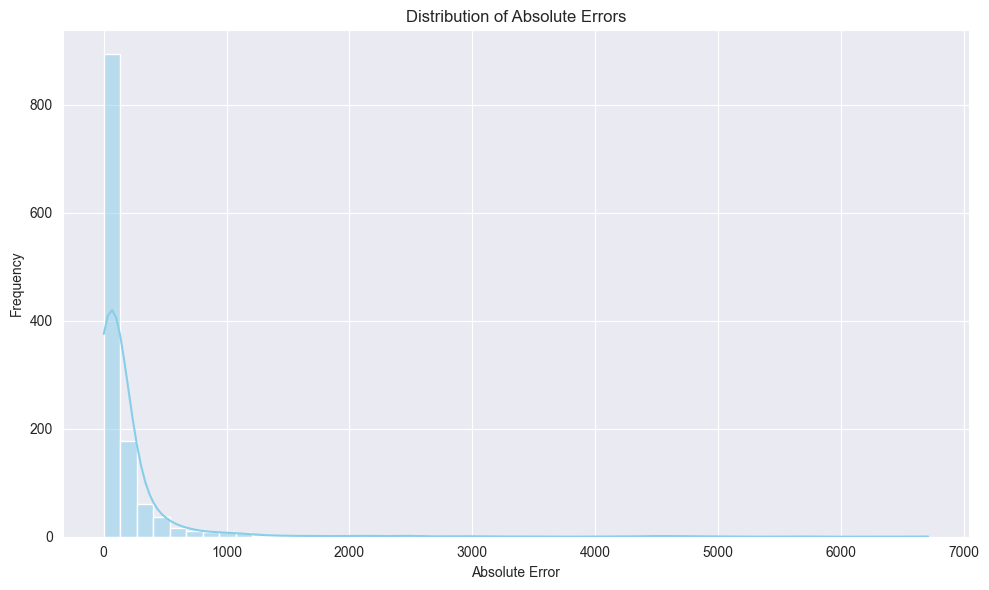

In [24]:
# Adjust pandas display options
pd.set_option('display.max_columns', None)       # Show all columns
pd.set_option('display.max_colwidth', None)      # Show full content in columns

# Create a copy for error_df
error_df = comparison_df.copy()

# Identify top 20 worst predictions
worst_predictions = error_df.nlargest(20, 'error')
print("Top 20 Worst Predictions:")
display(worst_predictions)

# Identify top 20 best predictions
best_predictions = error_df.nsmallest(20, 'error')
print("\nTop 20 Best Predictions:")
display(best_predictions)

# Visualization: Histogram of Errors
plt.figure(figsize=(10, 6))
sns.histplot(data=error_df, x='error', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Is the model mostly overestimating or underestimating?
As we can see from the visualization, the model is mostly underestimating.
I'll explain why I think that is, below.

                 Count  Percentage
Underestimation    665       53.37
Overestimation     581       46.63


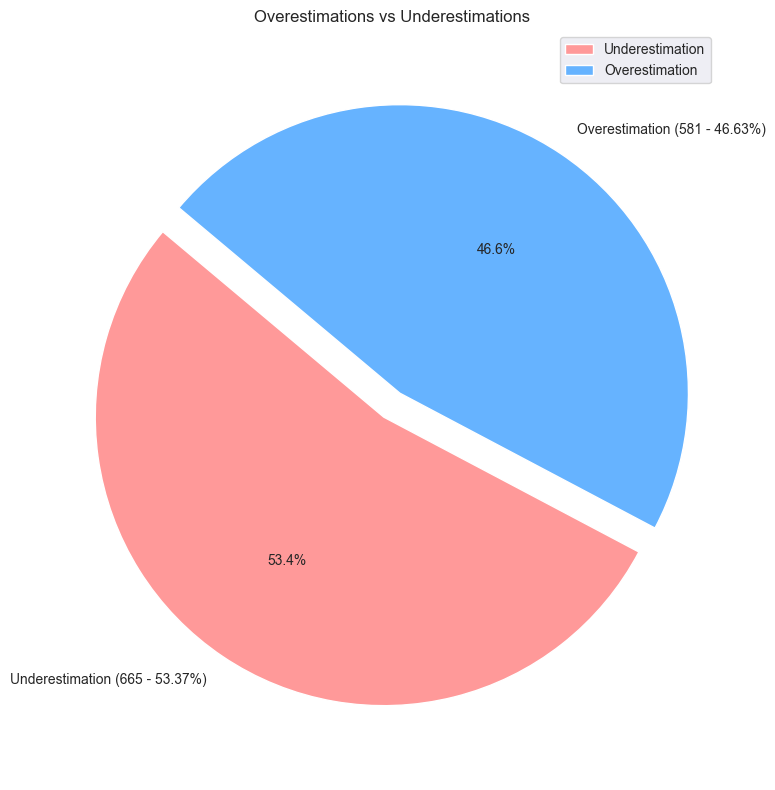

In [25]:
# Categorize each prediction
def categorize(row):
    if row['predicted'] > row['actual']:
        return 'Overestimation'
    elif row['predicted'] < row['actual']:
        return 'Underestimation'
    else:
        return 'Perfect Prediction'

comparison_df['category'] = comparison_df.apply(categorize, axis=1)

# Exclude perfect predictions
filtered_df = comparison_df[comparison_df['category'] != 'Perfect Prediction']

# Calculate counts and percentages
counts = filtered_df['category'].value_counts()
percentages = filtered_df['category'].value_counts(normalize=True) * 100
summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

print(summary)

# Define labels with counts and percentages
labels = [f"{category} ({count} - {percentage}%)" 
          for category, count, percentage in zip(summary.index, summary['Count'], summary['Percentage'])]

# Define sizes
sizes = summary['Count']

# Define colors
colors = ['#ff9999','#66b3ff']

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, 
        explode=(0.05, 0.05))  # Slightly explode each slice for emphasis

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Overestimations vs Underestimations')
plt.legend(summary.index, loc="best")
plt.tight_layout()
plt.show()

On the next visualization we'll check the distribution of actual prices by category (overestimation - blue or underestimation -red).
My hypothesis is that it's happening because our price distribution is right-skewed (there's a large mass of observations in the lower-mid price range),
 and because of the nature of the model we used (aims to minimize a loss function). Since the majority of training examples have lower-mid prices, the model’s optimization process will focus on fitting these well, at the expense of the high-priced ones. We can see that the point in which the tide changes from overestimation to underestimation is around the mean or median (mentioned above) and that makes sense.

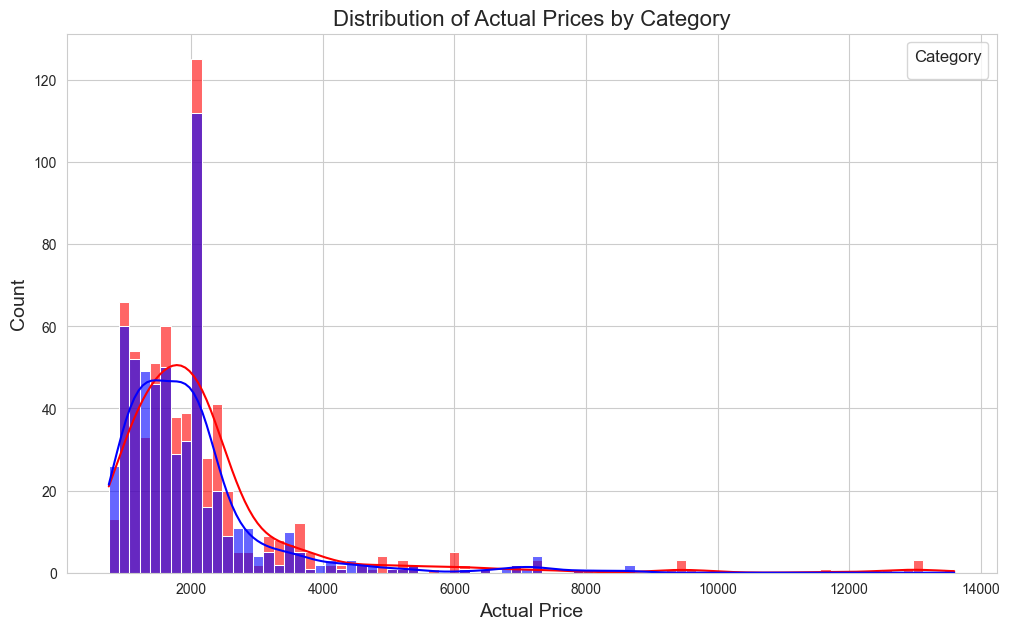

In [26]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the color palette
palette = {'Overestimation': 'blue', 'Underestimation': 'red'}

# Create the plot
plt.figure(figsize=(12, 7))
sns.histplot(
    data=filtered_df,
    x='actual',
    hue='category',
    palette=palette,
    kde=True,
    multiple='layer',
    alpha=0.6
)

# Add titles and labels
plt.title('Distribution of Actual Prices by Category', fontsize=16)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Customize legend
plt.legend(title='Category', title_fontsize=12, fontsize=12)

# Show the plot
plt.show()

Are some features sabotaging the model?
Yes. I found below that the shape feature actually sabotages the model performance.
I think it is caused by the fact that this feature is very imbalanced, there are shapes for which we have thousands of samples for (Round) and there are shapes we have less than a hundred samples for (Marquise). This, in addition to the one-hot encoding that increases the dimension of our feature space can cause the model to overfit.


In [27]:
# Define your feature groups
feature_groups = {
    'weight': ['weight'],
    'length': ['length'],
    'width': ['width'],
    'depth': ['depth'],
    'shape': ['shape_CUSHION', 'shape_EMERALD', 'shape_HEART', 'shape_MARQUISE', 
              'shape_OVAL', 'shape_PEAR', 'shape_PRINCESS', 'shape_ROUND'],
    'clarity': ['encoded_clarity'],
    'color': ['encoded_color'],
    'cut': ['encoded_cut'],
    'polish': ['encoded_polish'],
    'symmetry': ['encoded_symmetry'],
    'fluorescence': ['encoded_fluorescence']
}

# Define the performance metric
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return mse, r2

# Dictionary to store performance after feature removal
performance_after_removal = {}

# Iterate over each feature group, remove it, train and evaluate the model
for feature, cols in feature_groups.items():
    # Create new training and testing sets without the current feature
    X_train_reduced = X_train.drop(columns=cols)
    X_test_reduced = X_test.drop(columns=cols)
    
    # Initialize and train the model
    model = XGBRegressor(objective='reg:squarederror', random_state=42) # Initialize a new model instance
    model.fit(X_train_reduced, y_train)
    
    # Evaluate the model
    mse, r2 = evaluate_model(model, X_test_reduced, y_test)
    
    # Store the results
    performance_after_removal[feature] = {
        'MSE': mse,
        'R2': r2,
        'MSE_Diff': mse - baseline_mean_squared_error,
        'R2_Diff': r2 - baseline_r2_score
    }
    
    print(f"After removing '{feature}':")
    print(f" - MSE: {mse:.4f} (Δ: {mse - baseline_mean_squared_error:.4f})")
    print(f" - R²: {r2:.4f} (Δ: {r2 - baseline_r2_score:.4f})\n")

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(performance_after_removal).T

# Display the results sorted by MSE_Diff for general insight
results_df_sorted = results_df.sort_values(by='MSE_Diff', ascending=False)
print("Feature Removal Impact (sorted by MSE increase):")
print(results_df_sorted)

# Identify sabotaging features: removal improves model performance
sabotaging_features = results_df[
    (results_df['MSE_Diff'] < 0) | (results_df['R2_Diff'] > 0)
]

if not sabotaging_features.empty:
    # Sort sabotaging features by the magnitude of improvement
    sabotaging_features = sabotaging_features.sort_values(
        by=['MSE_Diff', 'R2_Diff'], 
        ascending=[True, False]
    )
    print("\nSabotaging Features (Removal Improves Model Performance):")
    print(sabotaging_features)
else:
    # No sabotaging features found; list top features that hurt the least when removed
    # You can sort by smallest MSE_Diff or smallest absolute R2_Diff
    # Here, we'll sort by smallest MSE_Diff (smallest increase in MSE)
    least_harming_features = results_df.sort_values(by='MSE_Diff', ascending=True).head(5)
    print("\nNo sabotaging features found.")
    print("Top 5 Features that Hurt Model Performance the Least when Removed:")
    print(least_harming_features)

After removing 'weight':
 - MSE: 360906.7230 (Δ: 61943.4898)
 - R²: 0.8269 (Δ: -0.0297)

After removing 'length':
 - MSE: 329364.0394 (Δ: 30400.8062)
 - R²: 0.8420 (Δ: -0.0146)

After removing 'width':
 - MSE: 334607.3669 (Δ: 35644.1338)
 - R²: 0.8395 (Δ: -0.0171)

After removing 'depth':
 - MSE: 325467.7278 (Δ: 26504.4947)
 - R²: 0.8439 (Δ: -0.0127)

After removing 'shape':
 - MSE: 289826.3018 (Δ: -9136.9314)
 - R²: 0.8610 (Δ: 0.0044)

After removing 'clarity':
 - MSE: 538074.2310 (Δ: 239110.9978)
 - R²: 0.7419 (Δ: -0.1147)

After removing 'color':
 - MSE: 583394.7134 (Δ: 284431.4802)
 - R²: 0.7201 (Δ: -0.1364)

After removing 'cut':
 - MSE: 310140.1944 (Δ: 11176.9613)
 - R²: 0.8512 (Δ: -0.0054)

After removing 'polish':
 - MSE: 312256.0572 (Δ: 13292.8240)
 - R²: 0.8502 (Δ: -0.0064)

After removing 'symmetry':
 - MSE: 318252.2256 (Δ: 19288.9925)
 - R²: 0.8473 (Δ: -0.0093)

After removing 'fluorescence':
 - MSE: 317070.0408 (Δ: 18106.8077)
 - R²: 0.8479 (Δ: -0.0087)

Feature Removal Im